# Converting Audio into Spectrogram Images and Back

### Install dependencies

In [17]:
!pip install numpy scipy librosa imageio natsort scikit-image

## Import dependencies

In [2]:
# Miscellaneous
import os
import glob
import time
from natsort import natsorted

# Scientific
import numpy as np
import scipy
import librosa
from skimage.transform import resize
from beatbrain import fma

# Visualization
from PIL import Image
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
sns.set()
sns.set_style("white")
plt.rcParams['figure.figsize'] = (10, 5)

## Set up convenience functions

In [4]:
def load_audio(path, debug=True, **kwargs):
    start = time.time()
    audio, sr = librosa.load(path, **kwargs)
    if debug:
        print(f"Loaded {audio.size / sr:.3f} seconds of audio at sr={sr} in {time.time() - start:.2f}s")
        show_audio(audio, rate=sr)
    return audio, sr

def show_audio(audio, **kwargs):
    start = time.time()
    ipd.display(ipd.Audio(audio, **kwargs))

def show_spec(spec, scale_fn=librosa.power_to_db, title=None, **kwargs):
    spec = scale_fn(spec, ref=np.max)
    kwargs['cmap'] = kwargs.get('cmap') or "magma"
    sns.heatmap(spec[::-1],
                cbar_kws={'format': '%+2.0f dB'},
                xticklabels=False,
                yticklabels=False,
                cbar=False,
                **kwargs)
    plt.title(title)
    sns.despine(left=True, bottom=True)

def ncc(a, b, sweep=False):
    """
    Compute the normalized cross-correlation between two signals:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6147431/#sec001title
    
    Be careful when using this function with zero-arrays (returns 0)
    """
    eps = np.finfo(np.float).eps
    corr = scipy.signal.correlate(a, b)
    if not sweep:
        mid = ()
        for d in corr.shape:
            i = np.floor((d - 1) / 2).astype(int)
            mid += ((slice(i, i + 2) if d % 2 == 0 else [i]),)
        corr = corr[mid].mean(axis=0)
    norm = np.sqrt((a ** 2).sum() * (b ** 2).sum()) + eps
    return corr / norm

## Global constants - change as needed

In [5]:
AUDIO_PATH = "../data/fma/audio/000/000005.mp3"
START = 0
DURATION = 5
SAMPLE_RATE = 32768
N_FFT = 4096
HOP_LENGTH = 256
N_MELS = 512
CHUNK_SIZE = 640
RESAMPLE_TYPE = 'kaiser_fast'

## Load some audio

In [6]:
audio, sr = load_audio(AUDIO_PATH, sr=SAMPLE_RATE,
                       offset=START, duration=DURATION,
                       res_type=RESAMPLE_TYPE)

Loaded 5.000 seconds of audio at sr=32768 in 0.48s


### Downsample, Upsample

And compute normalized cross-correlation

In [7]:
print(f"Original ({sr}Hz):", ncc(audio, audio))
for ratio in [2, 4, 8]:
    downsampled = librosa.resample(audio, sr, sr // ratio)
    upsampled = librosa.resample(downsampled, sr // ratio, sr)
    print(f"{sr // ratio}Hz:", ncc(audio, upsampled))
    show_audio(upsampled, rate=sr)

Original (32768Hz): 0.9999999079830502
16384Hz: 0.9973182676451945


8192Hz: 0.990768721208563


4096Hz: 0.9825846576151387


## (STFT) Spectrogram

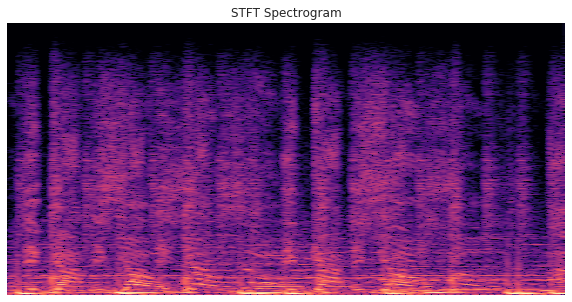

In [8]:
spec = np.abs(librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH))
show_spec(spec, scale_fn=librosa.amplitude_to_db, title="STFT Spectrogram")

## Mel Spectrogram

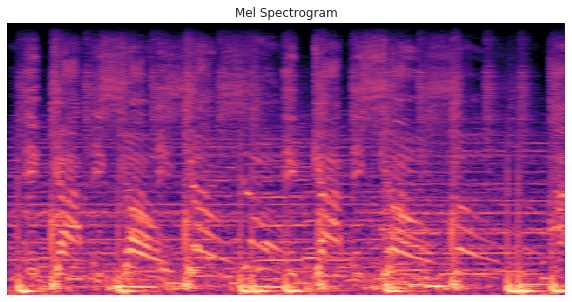

In [9]:
spec = librosa.feature.melspectrogram(audio, sr=sr, n_mels=N_MELS,
                                     n_fft=N_FFT, hop_length=HOP_LENGTH)
show_spec(spec, title="Mel Spectrogram")

## Reconstruct Audio from a Mel Spectrogram

Spectrogram shape: (512, 641)
Reconstructed 163840 samples (5.00s)
Audio NCC: -0.288926197352183
Spectrogram NCC: 0.9986870708863098


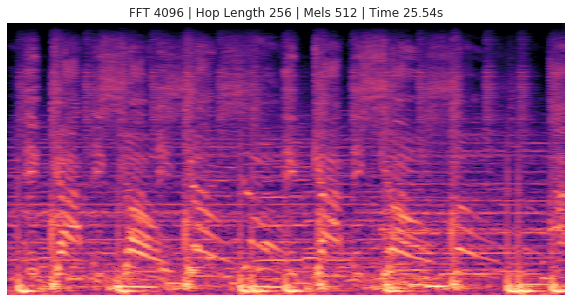

Spectrogram shape: (256, 641)
Reconstructed 163840 samples (5.00s)
Audio NCC: -0.07129357780636615
Spectrogram NCC: 0.9551596278549431


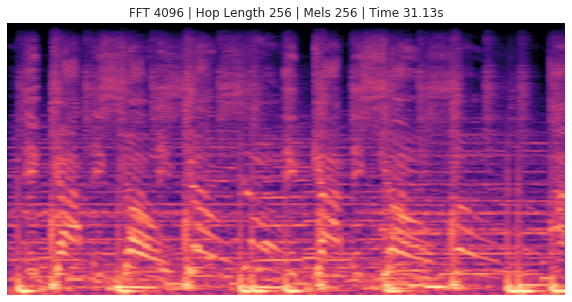

Spectrogram shape: (128, 641)
Reconstructed 163840 samples (5.00s)
Audio NCC: 0.06999486429192991
Spectrogram NCC: 0.94622101921962


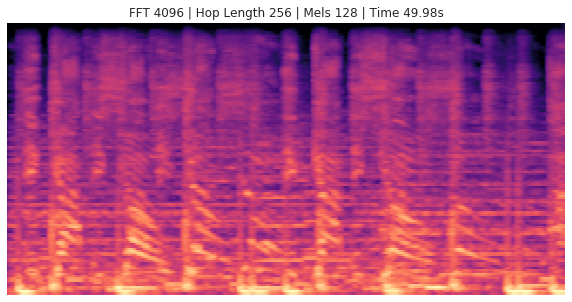

In [21]:
configs = [
    {'n_mels': 512, 'n_fft': 4096, 'hop_length': 256},
    {'n_mels': 256, 'n_fft': 4096, 'hop_length': 256},
    {'n_mels': 128, 'n_fft': 4096, 'hop_length': 256},
]

for config in configs:
    n_fft, hop_length, n_mels = config['n_fft'], config['hop_length'], config['n_mels']
    spec = librosa.feature.melspectrogram(audio, sr=sr,
                                          n_mels=n_mels, n_fft=n_fft,
                                          hop_length=hop_length)
    start = time.time()
    recon = librosa.feature.inverse.mel_to_audio(spec, sr=sr, n_fft=n_fft,
                                                 hop_length=hop_length)
    elapsed = time.time() - start
    recon_spec = librosa.feature.melspectrogram(recon, sr=sr, n_mels=N_MELS,
                                                n_fft=N_FFT, hop_length=HOP_LENGTH)
    print(f"Spectrogram shape: {spec.shape}")
    print(f"Reconstructed {len(recon)} samples ({len(recon) / sr:.2f}s)")
    print(f"Audio NCC: {ncc(audio, recon)}")
    print(f"Spectrogram NCC: {ncc(spec, resize(recon_spec, spec.shape))}")
    title = f"FFT {n_fft} | Hop Length {hop_length} | Mels {n_mels} | Time {elapsed:.2f}s"
    show_spec(spec, title=title)
    plt.show()
    show_audio(recon, rate=sr)
    print("=================================================================================")

#### Convert Audio to Image and back

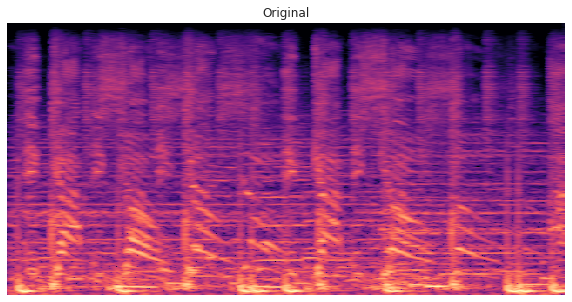

Spectrogram NCC: 0.9995055837492356


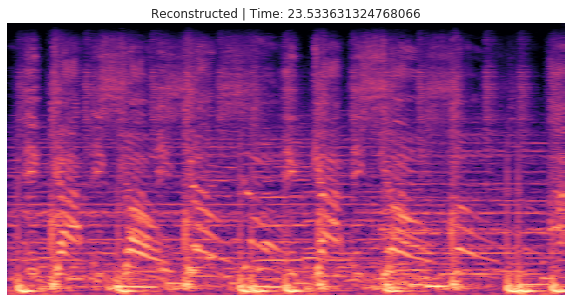

Audio NCC: 0.08958511693990938


In [14]:
import imageio
from sklearn.preprocessing import MinMaxScaler
imageio.plugins.freeimage.download()  # Download EXR library if not present

# Compute and save spectrogram as EXR image
spec = librosa.feature.melspectrogram(audio, sr=sr, n_mels=N_MELS,
                                      n_fft=N_FFT, hop_length=HOP_LENGTH)
show_spec(spec, title="Original")
plt.show()
show_audio(audio, rate=sr)
imageio.imwrite('spec.exr', ((librosa.power_to_db(spec, ref=np.max) / 80) + 1)[::-1])

# Reconstruct audio from EXR image
spec = imageio.imread('spec.exr')[::-1]
spec = librosa.db_to_power((spec - 1) * 80, ref=32768)
start = time.time()
recon = librosa.feature.inverse.mel_to_audio(spec, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
recon_spec = librosa.feature.melspectrogram(recon, sr=sr, n_mels=N_MELS,
                                            n_fft=N_FFT, hop_length=HOP_LENGTH)
print(f"Spectrogram NCC: {ncc(spec, recon_spec)}")
show_spec(recon_spec, title=f"Reconstructed | Time: {time.time() - start}")
plt.show()
print(f"Audio NCC: {ncc(audio, recon)}")
show_audio(recon, rate=sr)